In [70]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [71]:
num_particles = 1
# train_x = torch.rand(100)
train_x = torch.linspace(0, 1, 20)

# train_y = torch.stack([
#     torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
#     torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
# ], -1)

def true_func(x):
    return torch.cos(x * (2 * math.pi)) + 1 / 2 * torch.cos(4 * x * (2 * math.pi))

train_y = (true_func(train_x) + torch.randn(train_x.size()) * 0.2)[:,None].repeat(1, num_particles)

In [72]:
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_particles=10):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_particles]))
        self.covar_module_rbf = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_particles])),
            batch_shape=torch.Size([num_particles])
        )
        # for p in self.parameters():
        #     p.data = torch.randn_like(p.data)
            
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(1, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 5),
        )
        
    def forward(self, x):
        x = self.fc(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module_rbf(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_particles, noise_constraint=gpytorch.constraints.Interval(1e-3, 0.25))
model = BatchIndependentMultitaskGPModel(train_x, train_y, likelihood, num_particles=num_particles)

In [73]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.709
Iter 2/50 - Loss: 1.610
Iter 3/50 - Loss: 1.338
Iter 4/50 - Loss: 1.111
Iter 5/50 - Loss: 1.003
Iter 6/50 - Loss: 0.935
Iter 7/50 - Loss: 0.950
Iter 8/50 - Loss: 0.924
Iter 9/50 - Loss: 0.960
Iter 10/50 - Loss: 0.951
Iter 11/50 - Loss: 0.875
Iter 12/50 - Loss: 1.014
Iter 13/50 - Loss: 0.855
Iter 14/50 - Loss: 0.970
Iter 15/50 - Loss: 0.863
Iter 16/50 - Loss: 0.911
Iter 17/50 - Loss: 0.901
Iter 18/50 - Loss: 0.883
Iter 19/50 - Loss: 0.886
Iter 20/50 - Loss: 0.846
Iter 21/50 - Loss: 0.866
Iter 22/50 - Loss: 0.836
Iter 23/50 - Loss: 0.854
Iter 24/50 - Loss: 0.824
Iter 25/50 - Loss: 0.840
Iter 26/50 - Loss: 0.814
Iter 27/50 - Loss: 0.823
Iter 28/50 - Loss: 0.797
Iter 29/50 - Loss: 0.811
Iter 30/50 - Loss: 0.776
Iter 31/50 - Loss: 0.800
Iter 32/50 - Loss: 0.751
Iter 33/50 - Loss: 0.769
Iter 34/50 - Loss: 0.739
Iter 35/50 - Loss: 0.726
Iter 36/50 - Loss: 0.733
Iter 37/50 - Loss: 0.703
Iter 38/50 - Loss: 0.675
Iter 39/50 - Loss: 0.699
Iter 40/50 - Loss: 0.731
Iter 41/5

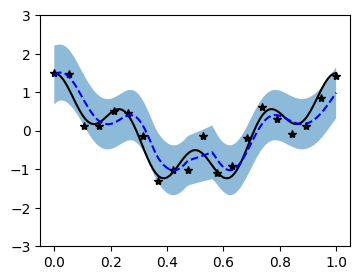

In [74]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axes = plt.subplots(1, 1, figsize=(4, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 101)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
for i_ax, _ax in enumerate(axes):
    # Plot training data as black stars
    _ax.plot(test_x.detach().numpy(), true_func(test_x).detach().numpy(), 'k-')
    # Plot training data as black stars
    _ax.plot(train_x.detach().numpy(), train_y[:, i_ax].detach().numpy(), 'k*')
    # Predictive mean as blue line
    _ax.plot(test_x.numpy(), mean[:, i_ax].numpy(), 'b--')
    # Shade in confidence
    _ax.fill_between(test_x.numpy(), lower[:, i_ax].numpy(), upper[:, i_ax].numpy(), alpha=0.5)
    _ax.set_ylim([-3, 3])
    # if i_ax == 0:
    #     _ax.legend(['Observed Data', 'Mean', 'Confidence'])
    #     _ax.set_title('Observed Values (Likelihood)')

None

